In [10]:
%pip install tensorboard
%pip install stable-baselines3
%pip install gymnasium
%pip install shimmy
%pip install torch
%pip install stable-baselines3 gym
%pip install matplotlib
%pip install kiwisolver

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached gymnasium-1.0.0a2-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-1.0.0a2-py3-none-any.whl (954 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0a2 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from math import sqrt
import matplotlib.pyplot as plt

In [12]:
def generador_data(fac, dem, deman_max):
    ancho = 2500
    cor_dem = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(dem)]
    dem_p = [random.randint(1, deman_max) for _ in range(dem)]  # Tamaño de puntos escalado para visualización

    cor_fac = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(fac)]

    # Crear el grafo
    G = nx.Graph()

    # Añadir nodos de demanda y facilidad al grafo
    for i, coord in enumerate(cor_dem):
        G.add_node(f"D{i}", pos=coord, demand=dem_p[i], color='red', size=dem_p[i])

    for j, coord in enumerate(cor_fac):
        G.add_node(f"F{j}", pos=coord, color='blue', size=100)  # Tamaño fijo para facilidades

    # Conectar nodos si cumplen una condición específica (e.g., todos conectados)
    cover=[]
    for i, c_dem in enumerate(cor_dem):
        for j, c_fac in enumerate(cor_fac):
            # Conectar si la distancia es menor a un umbral, ajustar según necesidad
            if sqrt((c_dem[0] - c_fac[0]) ** 2 + (c_dem[1] - c_fac[1]) ** 2) < 500:
                cover.append(1)
                G.add_edge(f"D{i}", f"F{j}")
            else:
                cover.append(0)

    cover=np.array(cover).reshape(fac,dem)
    # Establecer el tamaño de la figura (ancho x alto en pulgadas)
    plt.figure(figsize=(15, 15))  # Ajuste del tamaño de la figura a 15x15 pulgadas
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[node]['color'] for node in G.nodes]
    sizes = [G.nodes[node]['size'] for node in G.nodes]

    nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title('Red de Puntos de Demanda y Facilidades')
    plt.show()
    return dem_p,cover


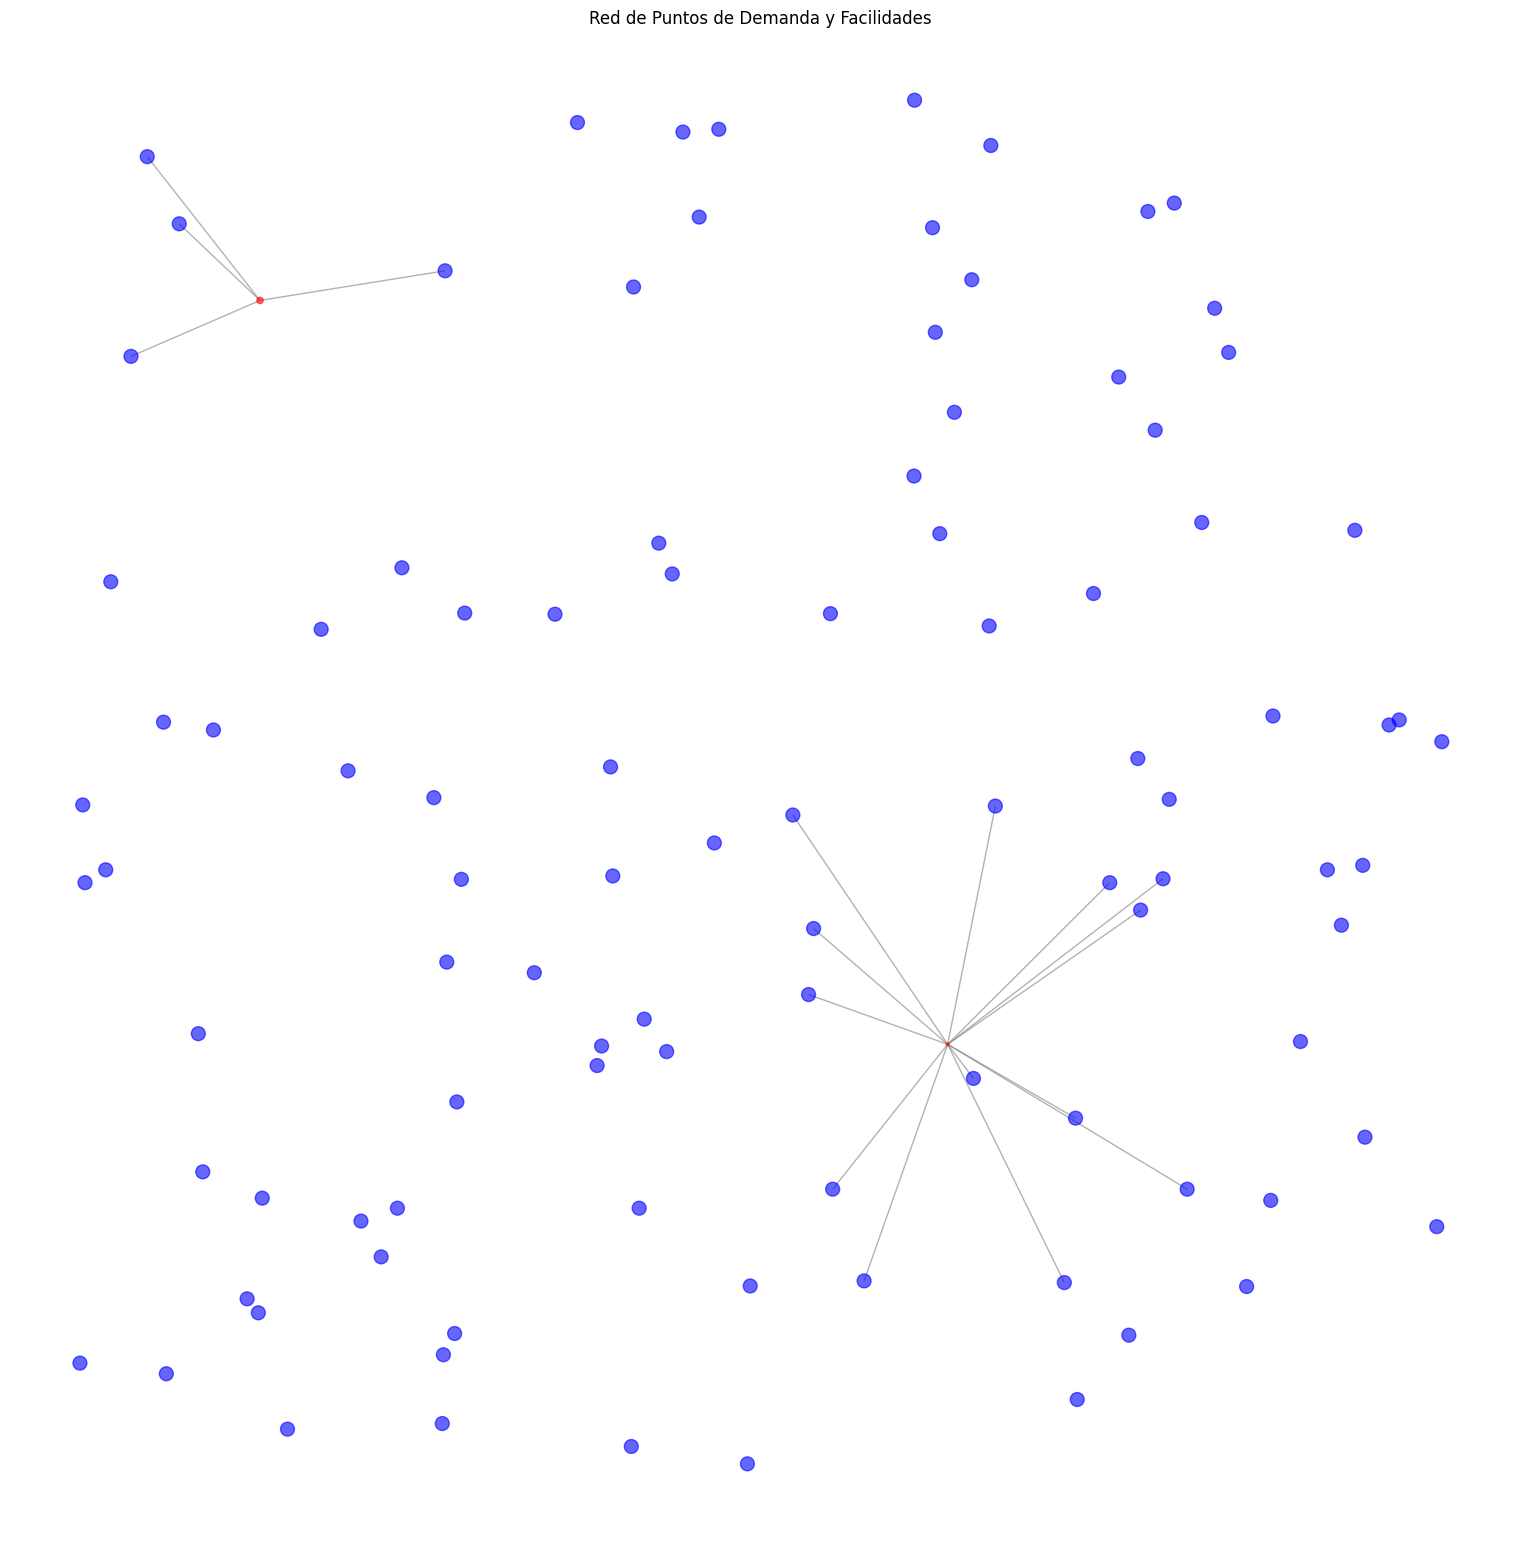

25


In [13]:
fac=100
demp=2
deman_max=40
demanda,m_cover=generador_data(fac, demp, deman_max)
print(sum(demanda))

In [14]:

i,j=m_cover.shape
dic={}
dem_fac={}
cover={}
for i in range(i):
    acum=[0,[]]
    dem_acum=0
    lista=[]
    for j in range(j):
        if m_cover[i][j]!=0:
            dem_acum+=int(m_cover[i][j])*demanda[j]
            acum[0]=dem_acum
            acum[1].append(demanda[j])
            lista.append(j)
    dic[i]=acum
    dem_fac[i]=dem_acum
    cover[i]=lista
dem_fac
dic
cover_dic=cover

In [16]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class HumanitarianFacilityLocationEnv(gym.Env):
    """Entorno para modelar la ubicación de facilidades en situaciones humanitarias."""
    def __init__(self, num_demand_points, num_facilities, num_days, coverage_dict, people_per_demand_point,
                 max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=100):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_demand_points = num_demand_points
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.current_day = 0
        self.coverage_dict = coverage_dict  # Diccionario de cobertura
        self.people_per_demand_point = np.array(people_per_demand_point, dtype=np.int32)
        self.demand_status = np.ones(self.num_demand_points, dtype=int)  # 1 = sin cubrir, 0 = cubierta
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = max_total_installations
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = max_total_installations
        self.action_space = spaces.MultiDiscrete([num_facilities, 6])  # Acciones: Poner 0-5 carpas en cada centro
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_demand_points,), dtype=np.uint8)

    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations
        self.demand_status.fill(1)  # Restablecer el estado de la demanda a no cubierta
        self.state = self.update_coverage()
        return self.state

    def update_coverage(self):
        # Calcula la capacidad utilizada por cada tienda para cada punto de demanda
        capacity_used_per_demand_point = np.zeros(self.num_demand_points)
        for facility_index in range(self.num_facilities):
            if facility_index in self.coverage_dict:
                covered_demand_points = self.coverage_dict[facility_index]
                capacity_used_per_demand_point[covered_demand_points] += self.installations_per_facility[facility_index] * self.max_capacity_per_facility
        # Actualiza el estado de la demanda
        self.state = np.where(capacity_used_per_demand_point >= self.people_per_demand_point, 0, 1)
        return self.state

    def step(self, action):
        facility_index, tents_to_add = action
        if tents_to_add > 0 and self.available_installations >= tents_to_add and self.installations_per_facility[facility_index] < self.max_installations_per_facility:
            self.installations_per_facility[facility_index] += tents_to_add
            self.available_installations -= tents_to_add
        reward = self.evaluate_reward()
        self.state = self.update_coverage()
        self.current_day += 1
        done = self.current_day >= self.num_days or np.all(self.state == 0)
        info = {}
        print(f"Estado actual: {self.state}")
        print(f"Demanda: {self.people_per_demand_point}")
        print(f"Instalaciones: {self.installations_per_facility}")
        print(f"Recompensa: {self.evaluate_reward()}")
        # Depurar la demanda por punto de demanda
        print(f"Demanda actual por punto de demanda (Día {self.current_day}, Paso {self.current_day * 1 + 1}):")
        return self.state, reward, done, info

    def evaluate_reward(self):
        # Reward for reducing the number of uncovered demands
        uncovered_people = np.sum(self.state * self.people_per_demand_point)
        total_capacity = np.sum(self.installations_per_facility * self.max_capacity_per_facility)
        capacity_reward = (total_capacity - uncovered_people) / total_capacity
        unused_capacity_penalty = (total_capacity - uncovered_people) / total_capacity
        num_tents_penalty = np.sum(self.installations_per_facility) * 0.1
        return -uncovered_people + capacity_reward - unused_capacity_penalty - num_tents_penalty

class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1):
        self.model = DQNNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:
            facility_index = random.randint(0, self.model.layer3.out_features // 6 - 1)
            tents_to_add = random.randint(0, 5)
            return (facility_index, tents_to_add)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
                # Encontrar la mejor acción válida
                best_action_index = torch.argmax(q_values).item()
                facility_index = best_action_index // 6
                tents_to_add = best_action_index % 6
                return (facility_index, tents_to_add)

    def update_model(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        # Convert action tuple to a single index 
        action_index = action[0] * 6 + action[1]  
        action = torch.LongTensor([action_index])  
        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        # Reshape action to be a 2D tensor
        action = action.view(-1, 1)  

        current_q = self.model(state).gather(1, action) 
        max_next_q = self.model(next_state).max(1)[0].detach()  # Obtener el Q máximo del siguiente estado
        expected_q = reward + 0.99 * max_next_q * (1 - done)  # Calcular el Q objetivo

        loss = self.criterion(current_q, expected_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Main execution
num_demand_points = demp  # Cantidad de puntos de demanda
num_facilities = fac  # Cantidad de instalaciones
num_days = 5
coverage_dict = cover_dic # Define tu diccionario de cobertura
people_per_demand_point = demanda  # Vector con el número de personas por punto de demanda
env = HumanitarianFacilityLocationEnv(num_demand_points=num_demand_points,
                                      num_facilities=num_facilities,
                                      num_days=num_days,
                                      coverage_dict=coverage_dict,
                                      people_per_demand_point=people_per_demand_point)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.nvec.prod()
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)
num_episodes = 10
demand_history_by_day = []  # Lista para guardar la demanda cubierta por día en cada episodio

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    demand_history_by_day.append([])  # Agrega una lista vacía para cada episodio

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        agent.update_model(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        env.update_coverage()

        # Actualizar la demanda faltante al final de cada día
        if env.current_day > 0 and env.current_day % 1 == 0:
            uncovered_people = np.sum(env.state * env.people_per_demand_point)  # Calcula la demanda no cubierta
            demand_history_by_day[-1].append(uncovered_people)  # Agrega la demanda faltante a la lista del episodio

    print(f"Episode {episode + 1}: Total Reward = {total_reward}, Uncovered People = {uncovered_people}")

for episode_index, episode_history in enumerate(demand_history_by_day):
    print(f"Episodio {episode_index + 1}:")
    for day_index, uncovered_people in enumerate(episode_history):
        print(f"Día {day_index + 1}: Demanda Faltante = {uncovered_people}")

# for episode_index, episode_history in enumerate(demand_history_by_day):
#     if(len(demand_history_by_day)-10<episode_index):
#         plt.figure()  # Crea una nueva figura para cada episodio
#         plt.plot(episode_history)
#         plt.xlabel("Día")
#         plt.ylabel("Demanda Cubierta")
#         plt.title(f"Episodio {episode_index + 1}: Demanda Cubierta por Día")
#         plt.show()


Estado actual: [1 1]
Demanda: [21  4]
Instalaciones: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recompensa: -25.4
Demanda actual por punto de demanda (Día 1, Paso 2):
Estado actual: [1 1]
Demanda: [21  4]
Instalaciones: [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recompensa: -25.9
Demanda actual por punto de demanda (Día 2, Paso 3):
Estado actual: [1 1]
Demanda: [21  4]
Instalaciones: [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recompensa: -26.1
Demanda actual por punto de demanda (Día 3, Paso 4):
Estado actual: [

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3540\2228391680.py:117: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  done = torch.FloatTensor([done])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3540\2228391680.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  capacity_reward = (total_capacity - uncovered_people) / total_capacity
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3540\2228391680.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  unused_capacity_penalty = (total_capacity - uncovered_people) / total_capacity
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3540\2228391680.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return -uncovered_people + capacity_reward - unused_capacity_penalty - num_tents_penalty
